In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Arrow, FancyArrow,FancyArrowPatch

import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np

from astropy.io import fits
import astropy.units as u
import astropy.constants as c
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import ascii
from scipy import interpolate 
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress,spearmanr,mannwhitneyu,ks_2samp

import warnings

In [2]:
xymass = Table.read('/Users/liuxihe/Desktop/band6_data_core_v2.txt',format='ascii')

In [3]:
def myMST(x_arr,y_arr,):
    '''
    To produce the minimum spaning tree of a series of points.
    ===========
    Parameters:
    x_arr: 1D array, x coordinate in pixel unit
    y_arr: 1D array, y coordinate in pixel unit
    
    ===========
    Returns:
    linkage: linkage between two cores
    link_length: link length of the linkage
    '''
    INF = 1e9
    N = len(x_arr) # number of vertices in graph
    pos = np.row_stack((x_arr,y_arr))
    G = squareform(pdist(pos.T))
    
    selected_node = np.zeros(N) # whether in link
    no_edge = 0
    selected_node[0] = True # start with the first one
    linkage = np.array([0,0,0,0])
    link_length = []
    
    while (no_edge < N - 1):
        minimum = INF
        a = 0
        b = 0
        for m in range(N):
            if selected_node[m]:
                for n in range(N):
                    if ((not selected_node[n]) and G[m][n]):  
                        # not in selected and there is an edge
                        if minimum > G[m][n]:
                            minimum = G[m][n]
                            a = m
                            b = n
        # print(str(a+1) + "-" + str(b+1) + ":" + str(G[a][b]))
        linkage = np.row_stack((linkage,np.array([x_arr[a],y_arr[a],x_arr[b],y_arr[b]])))
        link_length.append(G[a][b])
        # linkage = np.row_stack((linkage,np.array([x_arr[b],y_arr[b]])))
        selected_node[b] = True
        no_edge += 1
        
    return linkage[1:N], link_length

def mediandev(arr):
    median_value = np.median(arr)
    meddev_value = np.median([abs(x - median_value) for x in arr])
    return median_value,meddev_value

def Lbar_Nmst(x_arr,y_arr,Nmst,random_time=1000,method='mean'):
    Lrandom = []
    for i in range(random_time):
        indices = np.random.permutation(np.arange(len(x_arr)))[:Nmst]
        indices = np.sort(indices)
        x_arr_random = x_arr[indices]
        y_arr_random = y_arr[indices]
        linkage,lengths = myMST(x_arr_random,y_arr_random)
        if method=='mean':
            Lrandom.append(np.mean(lengths))
        elif method=='median':
            Lrandom.append(np.median(lengths))
    if method=='mean':
        return np.mean(Lrandom),np.std(Lrandom),
        # x_arr_random,y_arr_random
    elif method=='median':
        med,meddev = mediandev(Lrandom)
        return med,meddev

def Lms_Nmst(x_arr,y_arr,M_arr,Nmst,method='mean'):
    # sort the array inversely
    M_sorted = np.sort(M_arr)[::-1][:Nmst]
    indices = np.argsort(M_arr)[::-1][:Nmst]
    x_arr_sorted = x_arr[indices]
    y_arr_sorted = y_arr[indices]
    linkage,lengths = myMST(x_arr_sorted,y_arr_sorted)
    if method=='mean':
        return np.mean(lengths),
        # x_arr_sorted,y_arr_sorted
    elif method=='median':
        return np.median(lengths)

In [4]:
x_arr = xymass['col2']
y_arr = xymass['col3']
M_arr = xymass['col6']
Lambda_MSR = []
eLambda_MSR = []
for Nmst in range(2,len(x_arr)+1):
# for Nmst in [len(x_arr)]:
    print(Nmst,'MST knots are extracted out of', len(x_arr), 'knots')
    Lbar,eLbar, = Lbar_Nmst(x_arr,y_arr,Nmst,method='mean')
    Lms, = Lms_Nmst(x_arr,y_arr,M_arr,Nmst,method='mean')
    Lambda_MSR.append(Lbar/Lms)
    eLambda_MSR.append(eLbar/Lms)
    
Lambda_MSR = np.array(Lambda_MSR)
eLambda_MSR = np.array(eLambda_MSR)

2 MST knots are extracted out of 93 knots
3 MST knots are extracted out of 93 knots
4 MST knots are extracted out of 93 knots
5 MST knots are extracted out of 93 knots
6 MST knots are extracted out of 93 knots
7 MST knots are extracted out of 93 knots
8 MST knots are extracted out of 93 knots
9 MST knots are extracted out of 93 knots
10 MST knots are extracted out of 93 knots
11 MST knots are extracted out of 93 knots
12 MST knots are extracted out of 93 knots
13 MST knots are extracted out of 93 knots
14 MST knots are extracted out of 93 knots
15 MST knots are extracted out of 93 knots
16 MST knots are extracted out of 93 knots
17 MST knots are extracted out of 93 knots
18 MST knots are extracted out of 93 knots
19 MST knots are extracted out of 93 knots
20 MST knots are extracted out of 93 knots
21 MST knots are extracted out of 93 knots
22 MST knots are extracted out of 93 knots
23 MST knots are extracted out of 93 knots
24 MST knots are extracted out of 93 knots
25 MST knots are ex

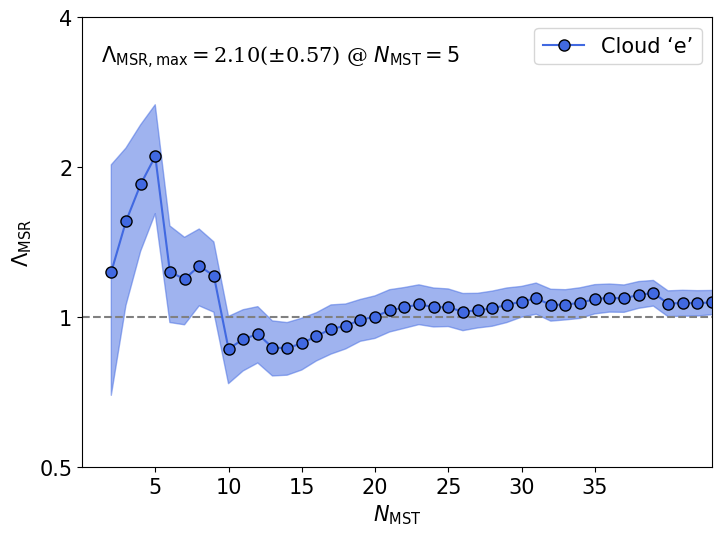

In [5]:
# draw mass segregation ratio plots

fig = plt.figure(figsize=(7,5))
ax1 = fig.add_axes([0.1,0.1,0.9,0.9])
 
modified_yerr = np.array([eLambda_MSR/Lambda_MSR*(Lambda_MSR-1/2*eLambda_MSR),eLambda_MSR])
ax1.errorbar(x=np.linspace(2,len(Lambda_MSR)+1,len(Lambda_MSR)),y=Lambda_MSR,
             # yerr=modified_yerr,
             fmt='o-',mfc='royalblue',mec='k',ecolor='royalblue',color='royalblue',
             capsize=3,capthick=1,alpha=1.0,markersize=8,label='Cloud ‘e’')

ax1.fill_between(np.linspace(2,len(Lambda_MSR)+1,len(Lambda_MSR)),y1=Lambda_MSR+modified_yerr[1],y2=Lambda_MSR-modified_yerr[0],
                 # label=fields[i],
                 alpha=0.5,color='royalblue')

ax1.set_xscale('linear')
ax1.set_xlim((0,43))
ax1.plot(np.linspace(0,43),np.linspace(1,1,),ls='--',color='grey',)
ax1.set_xticks([5,10,15,20,25,30,35])
ax1.set_xticklabels(['5','10','15','20','25','30','35'],
                    fontdict={'fontsize': 15,
                              'fontweight': 'normal'})
ax1.set_xlabel('$N_\mathrm{MST}$',fontdict={'fontsize':15})

ax1.set_yscale('log')
ax1.set_ylim((0.5,4))
ax1.set_yticks([0.5,1,2,4])
ax1.set_yticklabels(['0.5','1','2','4'],
                    fontdict={'fontsize': 15,
                              'fontweight': 'normal'})
ax1.set_ylabel('$\Lambda_\mathrm{MSR}$',fontdict={'fontsize':15})
ax1.tick_params(axis='both', labelsize=15)
ax1.minorticks_off()

ax1.legend(loc='upper right',fontsize=15,ncol=2)

ax1.text(0.03,0.9,s=r'$\Lambda_\mathrm{MSR,max}=$%.2f($\pm$%.2f) @ $N_\mathrm{MST}=%d$' %(np.max(Lambda_MSR),eLambda_MSR[np.argmax(Lambda_MSR)],np.argmax(Lambda_MSR)+2),
         family='serif',transform=ax1.transAxes,size=15,color='k')
# ax1.text(1.05,0.5,s='core number: %d' %(len(xymass)),family='serif',ha='right',size=15,color='k')

plt.savefig('mass_segregation.pdf',bbox_inches='tight')